In [1]:
# Change the path if necessary
datasets_path = 'datasets'

import sys
import os

# Deploy AML code in colab
if 'google.colab' in sys.modules:
    if not os.path.exists('/content/applied-ml/'):
        !wget -q https://raw.githubusercontent.com/tsunrise/colab-github/main/colab_github.py
        import colab_github
        colab_github.github_auth(persistent_key=False)

        %cd /content/
        !git clone git@github.com:oz-e/applied-ml.git
        if not os.path.exists('/content/applied-ml/'):
            raise Exception('Please follow the instructions to add the SSH key to your account in order to clone private repo')

    %cd /content/applied-ml/

    # Install any other requirements (to be converted to requirements.txt)
    !pip install openai-clip

In [2]:
import os

if not os.path.exists("CuPL"):
    !git clone https://github.com/sarahpratt/CuPL.git

In [3]:
import numpy as np
import torch
import clip
from CuPL.imagenet_prompts.standard_image_prompts import imagenet_templates
from PIL import Image
import json
import matplotlib.pyplot as plt

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
model, preprocess = clip.load("ViT-B/16", device=device, jit=False)

In [6]:
import aml.datasets

dataset_test = aml.datasets.Flowers102(datasets_path, split='test')

In [7]:
classnames_sorted = [dataset_test.lab2cname[label_id] for label_id in sorted(dataset_test.lab2cname.keys())]

In [8]:
with torch.no_grad():
    label_ids = np.arange(len(classnames_sorted))
    cls_features = model.encode_text(clip.tokenize(classnames_sorted).to(device))
    cls_features /= cls_features.norm(dim=-1, keepdim=True)

    similarity = torch.triu(cls_features @ cls_features.T, diagonal=1).T
    similarity = similarity.cpu().numpy()

([], [])

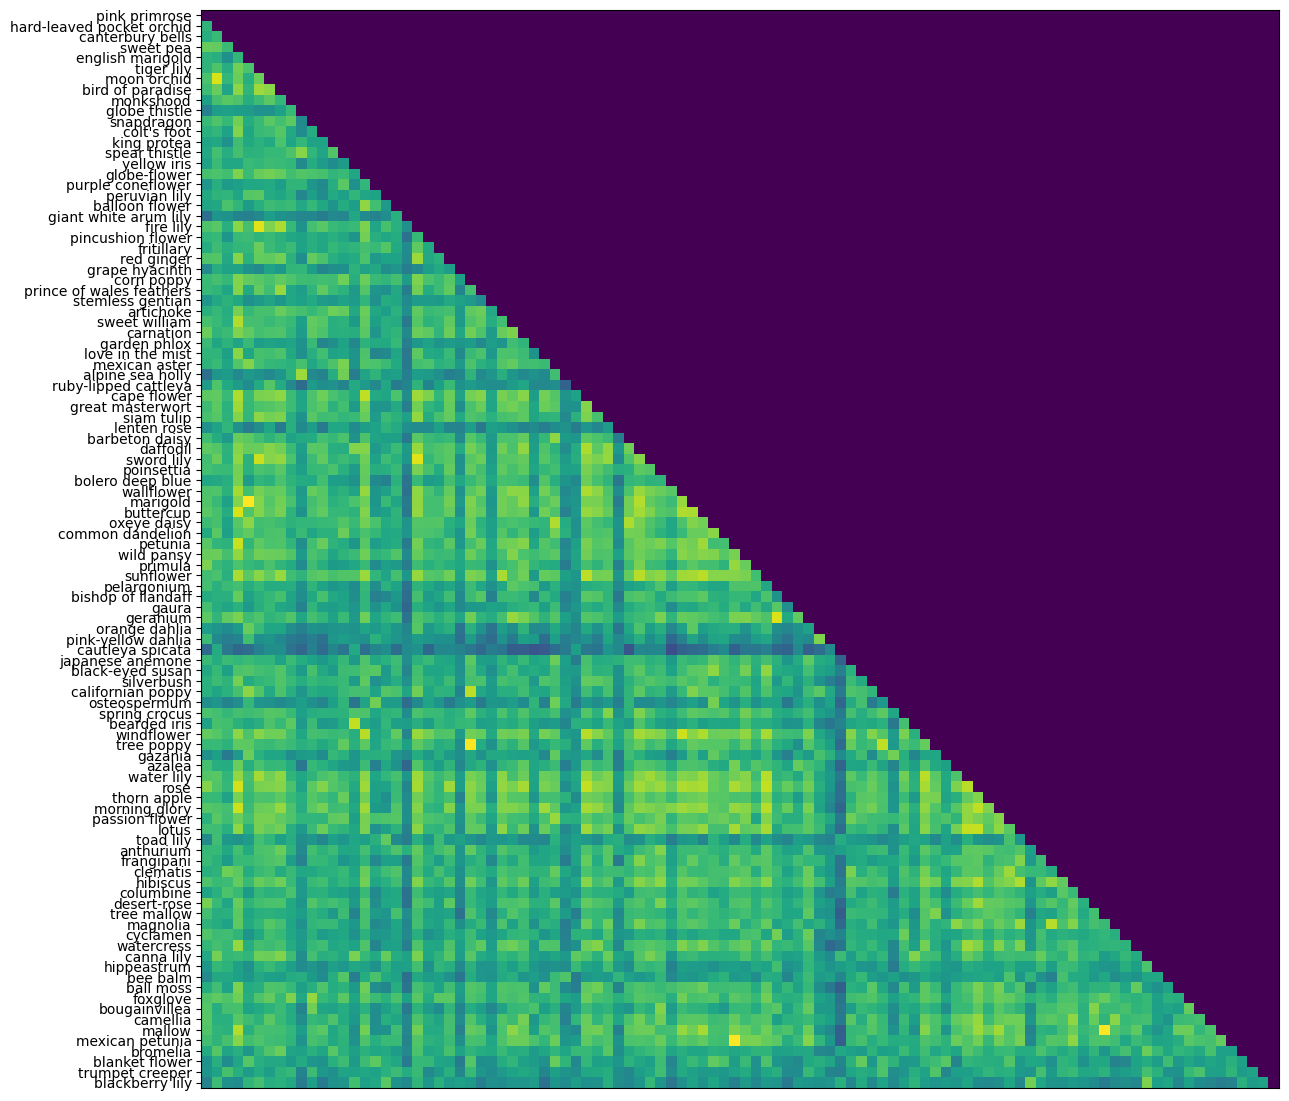

In [9]:
plt.figure(figsize=(20, 14))
plt.imshow(similarity)
plt.yticks(range(len(classnames_sorted)), classnames_sorted)
plt.xticks([])

In [10]:
average_similarity = np.mean(similarity)
print(f"Average similarity: {average_similarity}")

Average similarity: 0.28125


In [11]:
# Get the indices of top similarity values
top_indices = np.unravel_index(np.argsort(-similarity, axis=None)[:10], similarity.shape)

# Extract the class names and labels for top similarities
for idx, (label1, label2) in enumerate(zip(*top_indices)):
    print(f"Rank {idx}: ({label2}){classnames_sorted[label2]} - ({label1}){classnames_sorted[label1]}, Similarity: {similarity[label1, label2]}")

Rank 0: (50)petunia - (97)mexican petunia, Similarity: 0.88720703125
Rank 1: (4)english marigold - (46)marigold, Similarity: 0.8837890625
Rank 2: (25)corn poppy - (69)tree poppy, Similarity: 0.8828125
Rank 3: (85)tree mallow - (96)mallow, Similarity: 0.8818359375
Rank 4: (5)tiger lily - (20)fire lily, Similarity: 0.84521484375
Rank 5: (20)fire lily - (42)sword lily, Similarity: 0.84375
Rank 6: (54)pelargonium - (57)geranium, Similarity: 0.8408203125
Rank 7: (1)hard-leaved pocket orchid - (6)moon orchid, Similarity: 0.83447265625
Rank 8: (3)sweet pea - (47)buttercup, Similarity: 0.83447265625
Rank 9: (3)sweet pea - (73)rose, Similarity: 0.8251953125


In [12]:
import sklearn.manifold

tsne = sklearn.manifold.TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(cls_features.cpu().numpy())

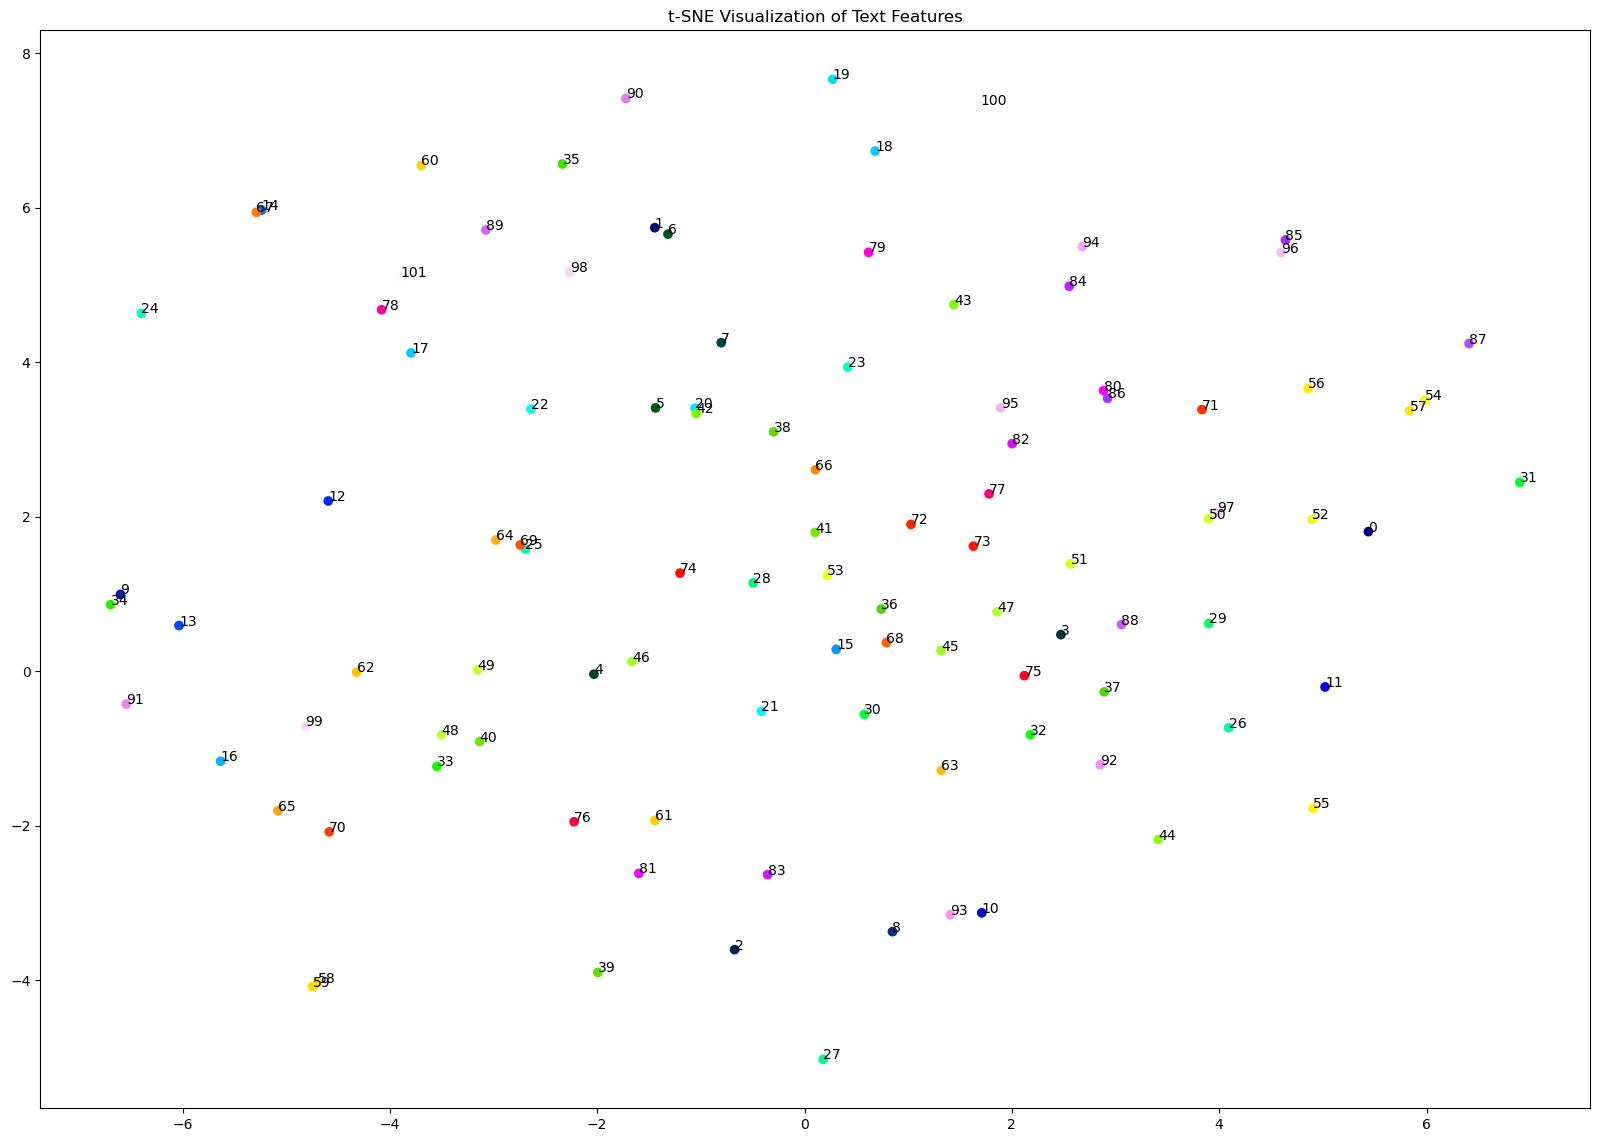

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 14))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=label_ids, cmap='gist_ncar')
for label_id in range(len(classnames_sorted)):
    plt.annotate(label_id, (tsne_features[label_ids == label_id, 0].mean(), tsne_features[label_ids == label_id, 1].mean()))
plt.title('t-SNE Visualization of Text Features')
plt.show()

In [14]:
label_texts_list = {label_id: [template.format(cls_name) for template in imagenet_templates] for label_id, cls_name in enumerate(classnames_sorted)}

In [15]:
with torch.no_grad():
    label_ids = []
    text_features = []
    cls_features = []
    for label_id, texts in label_texts_list.items():
        label_ids.append([label_id] * len(texts))
        class_embeddings = model.encode_text(clip.tokenize(texts).to(device))
        class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
        class_embedding = class_embeddings.mean(dim=0)
        class_embedding /= class_embedding.norm()
        text_features.append(class_embeddings)
        cls_features.append(class_embedding)
    label_ids = np.hstack(label_ids)
    text_features = torch.vstack(text_features).cpu().numpy()
    cls_features = torch.stack(cls_features)

    similarity = torch.triu(cls_features @ cls_features.T, diagonal=1).T
    similarity = similarity.cpu().numpy()

([], [])

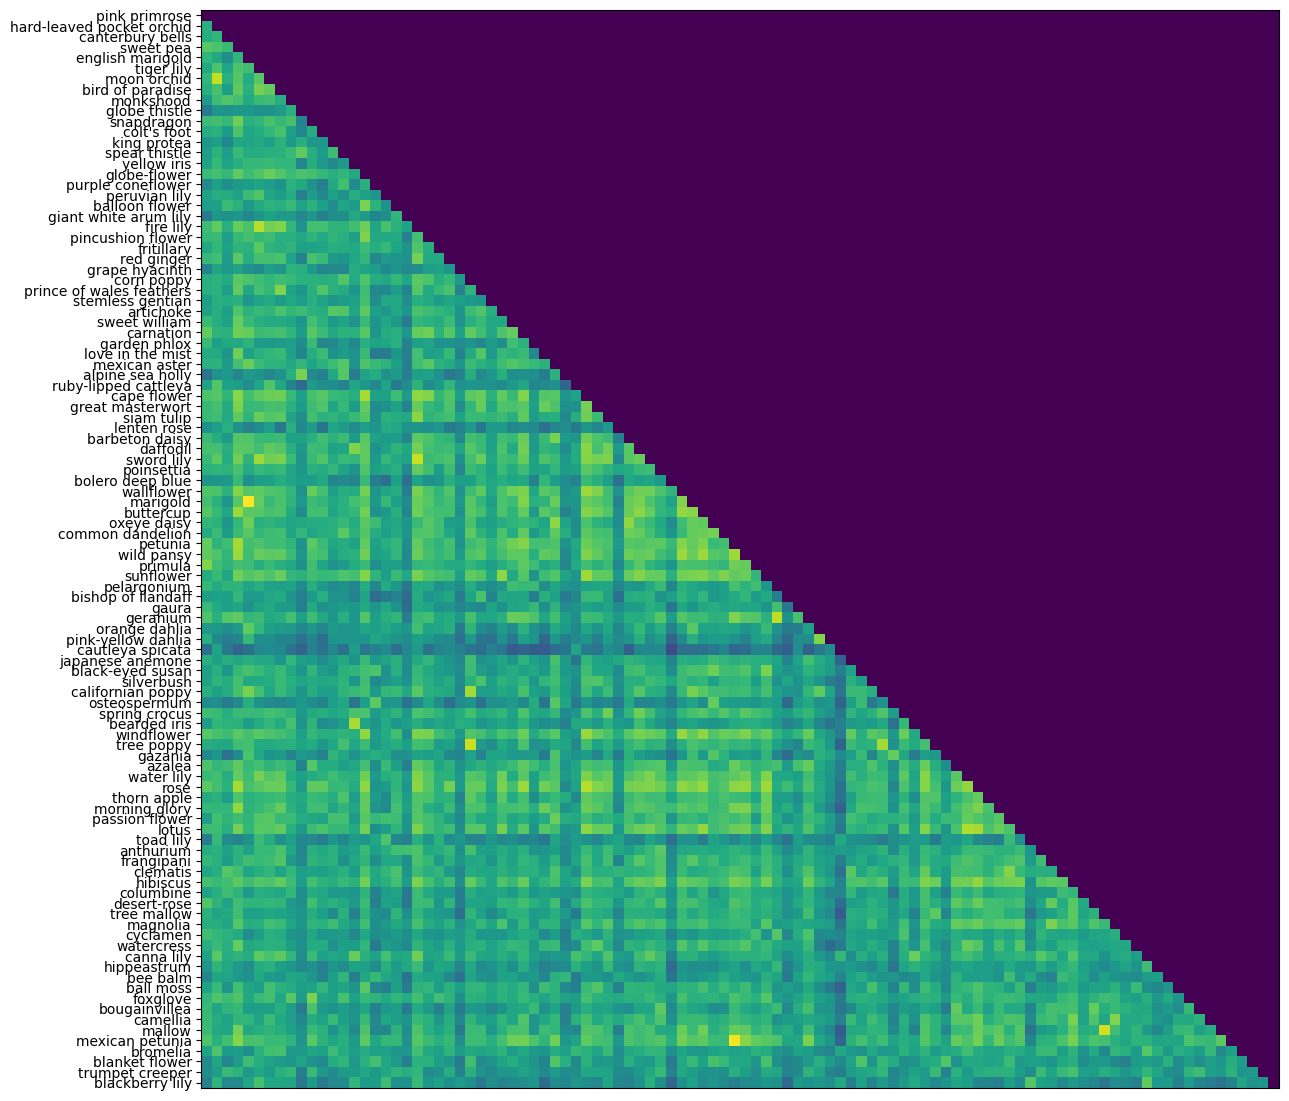

In [16]:
plt.figure(figsize=(20, 14))
plt.imshow(similarity)
plt.yticks(range(len(classnames_sorted)), classnames_sorted)
plt.xticks([])

In [17]:
average_similarity = np.mean(similarity)
print(f"Average similarity: {average_similarity}")

Average similarity: 0.288818359375


In [18]:
# Get the indices of top similarity values
top_indices = np.unravel_index(np.argsort(-similarity, axis=None)[:10], similarity.shape)

# Extract the class names and labels for top similarities
for idx, (label1, label2) in enumerate(zip(*top_indices)):
    print(f"Rank {idx}: ({label2}){classnames_sorted[label2]} - ({label1}){classnames_sorted[label1]}, Similarity: {similarity[label1, label2]}")

Rank 0: (4)english marigold - (46)marigold, Similarity: 0.95703125
Rank 1: (50)petunia - (97)mexican petunia, Similarity: 0.94384765625
Rank 2: (85)tree mallow - (96)mallow, Similarity: 0.890625
Rank 3: (25)corn poppy - (69)tree poppy, Similarity: 0.8818359375
Rank 4: (20)fire lily - (42)sword lily, Similarity: 0.87841796875
Rank 5: (1)hard-leaved pocket orchid - (6)moon orchid, Similarity: 0.86865234375
Rank 6: (54)pelargonium - (57)geranium, Similarity: 0.86376953125
Rank 7: (5)tiger lily - (20)fire lily, Similarity: 0.85107421875
Rank 8: (36)cape flower - (73)rose, Similarity: 0.8486328125
Rank 9: (72)water lily - (77)lotus, Similarity: 0.8447265625


In [19]:
import sklearn.manifold

tsne = sklearn.manifold.TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(text_features)

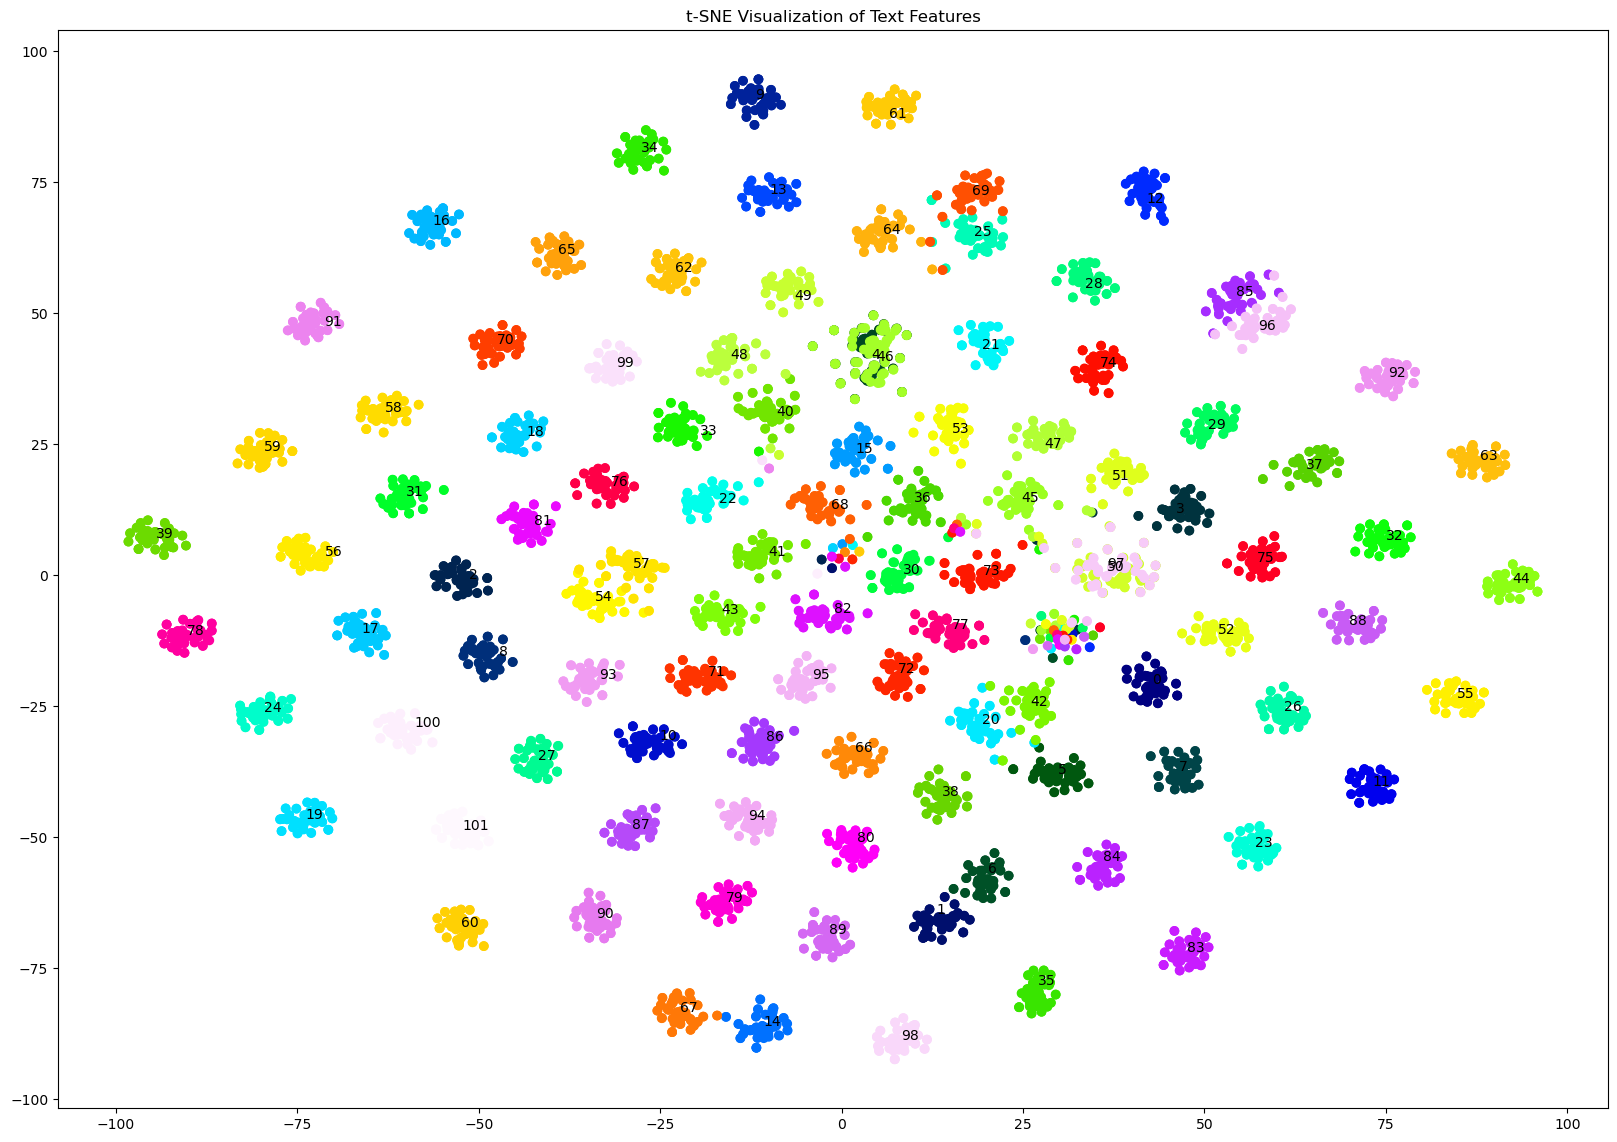

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 14))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=label_ids, cmap='gist_ncar')
for label_id in range(len(classnames_sorted)):
    plt.annotate(label_id, (tsne_features[label_ids == label_id, 0].mean(), tsne_features[label_ids == label_id, 1].mean()))
plt.title('t-SNE Visualization of Text Features')
plt.show()

In [21]:
PATH_TO_PROMPTS = './CuPL/all_prompts/full_prompts/flower_prompts_full.json'

with open(PATH_TO_PROMPTS) as f:
    gpt3_prompts = json.load(f)

In [22]:
special_class_mapping = {
    'globe flower': 'globe-flower',
    'pink and yellow dahlia': 'pink-yellow dahlia',
    'air plant': 'ball moss',
}

In [23]:
# For bridging classsname in dataset with name in CuLP prompts
new_gpt3_prompts = {}

for key, value in gpt3_prompts.items():
    new_key = special_class_mapping.get(key, key)
    new_gpt3_prompts[new_key.lower()] = value

In [24]:
label_texts_list = {label_id: new_gpt3_prompts[cls_name] for label_id, cls_name in enumerate(classnames_sorted)}

In [25]:
with torch.no_grad():
    label_ids = []
    text_features = []
    cls_features = []
    for label_id, texts in label_texts_list.items():
        label_ids.append([label_id] * len(texts))
        class_embeddings = model.encode_text(clip.tokenize(texts).to(device))
        class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
        class_embedding = class_embeddings.mean(dim=0)
        class_embedding /= class_embedding.norm()
        text_features.append(class_embeddings)
        cls_features.append(class_embedding)
    label_ids = np.hstack(label_ids)
    text_features = torch.vstack(text_features).cpu().numpy()
    cls_features = torch.stack(cls_features)

    similarity = torch.triu(cls_features @ cls_features.T, diagonal=1).T
    similarity = similarity.cpu().numpy()

([], [])

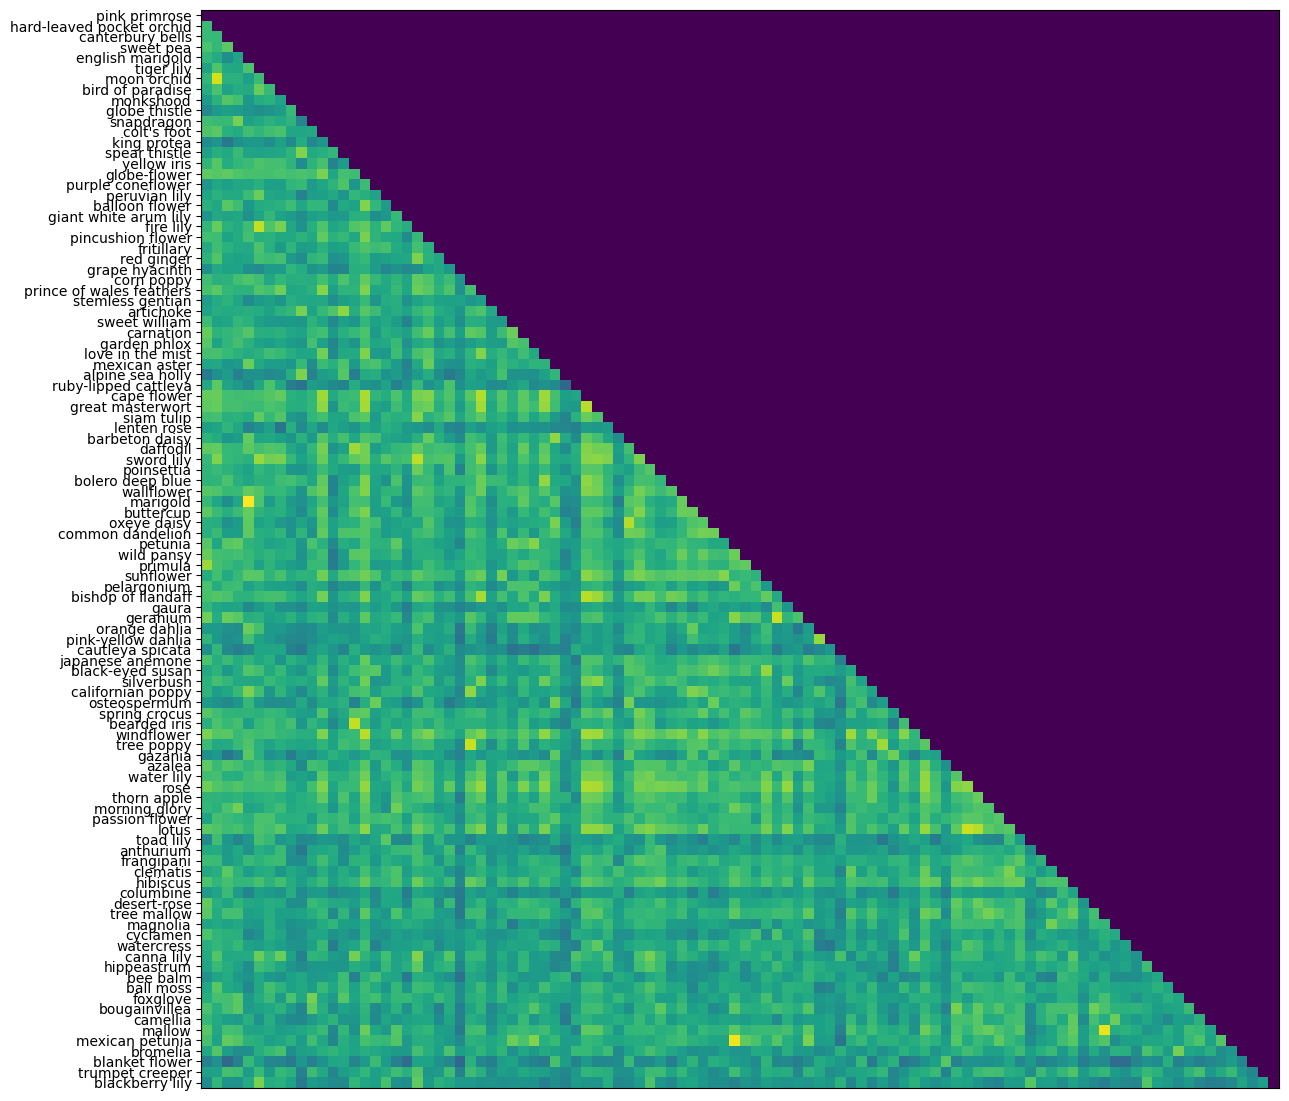

In [26]:
plt.figure(figsize=(20, 14))
plt.imshow(similarity)
plt.yticks(range(len(classnames_sorted)), classnames_sorted)
plt.xticks([])

In [27]:
average_similarity = np.mean(similarity)
print(f"Average similarity: {average_similarity}")

Average similarity: 0.298583984375


In [28]:
# Get the indices of top similarity values
top_indices = np.unravel_index(np.argsort(-similarity, axis=None)[:10], similarity.shape)

# Extract the class names and labels for top similarities
for idx, (label1, label2) in enumerate(zip(*top_indices)):
    print(f"Rank {idx}: ({label2}){classnames_sorted[label2]} - ({label1}){classnames_sorted[label1]}, Similarity: {similarity[label1, label2]}")

Rank 0: (4)english marigold - (46)marigold, Similarity: 0.978515625
Rank 1: (50)petunia - (97)mexican petunia, Similarity: 0.95703125
Rank 2: (85)tree mallow - (96)mallow, Similarity: 0.94677734375
Rank 3: (1)hard-leaved pocket orchid - (6)moon orchid, Similarity: 0.91455078125
Rank 4: (72)water lily - (77)lotus, Similarity: 0.8984375
Rank 5: (25)corn poppy - (69)tree poppy, Similarity: 0.8955078125
Rank 6: (54)pelargonium - (57)geranium, Similarity: 0.89501953125
Rank 7: (14)yellow iris - (67)bearded iris, Similarity: 0.88916015625
Rank 8: (5)tiger lily - (20)fire lily, Similarity: 0.888671875
Rank 9: (20)fire lily - (42)sword lily, Similarity: 0.8818359375


In [29]:
import sklearn.manifold

tsne = sklearn.manifold.TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(text_features)

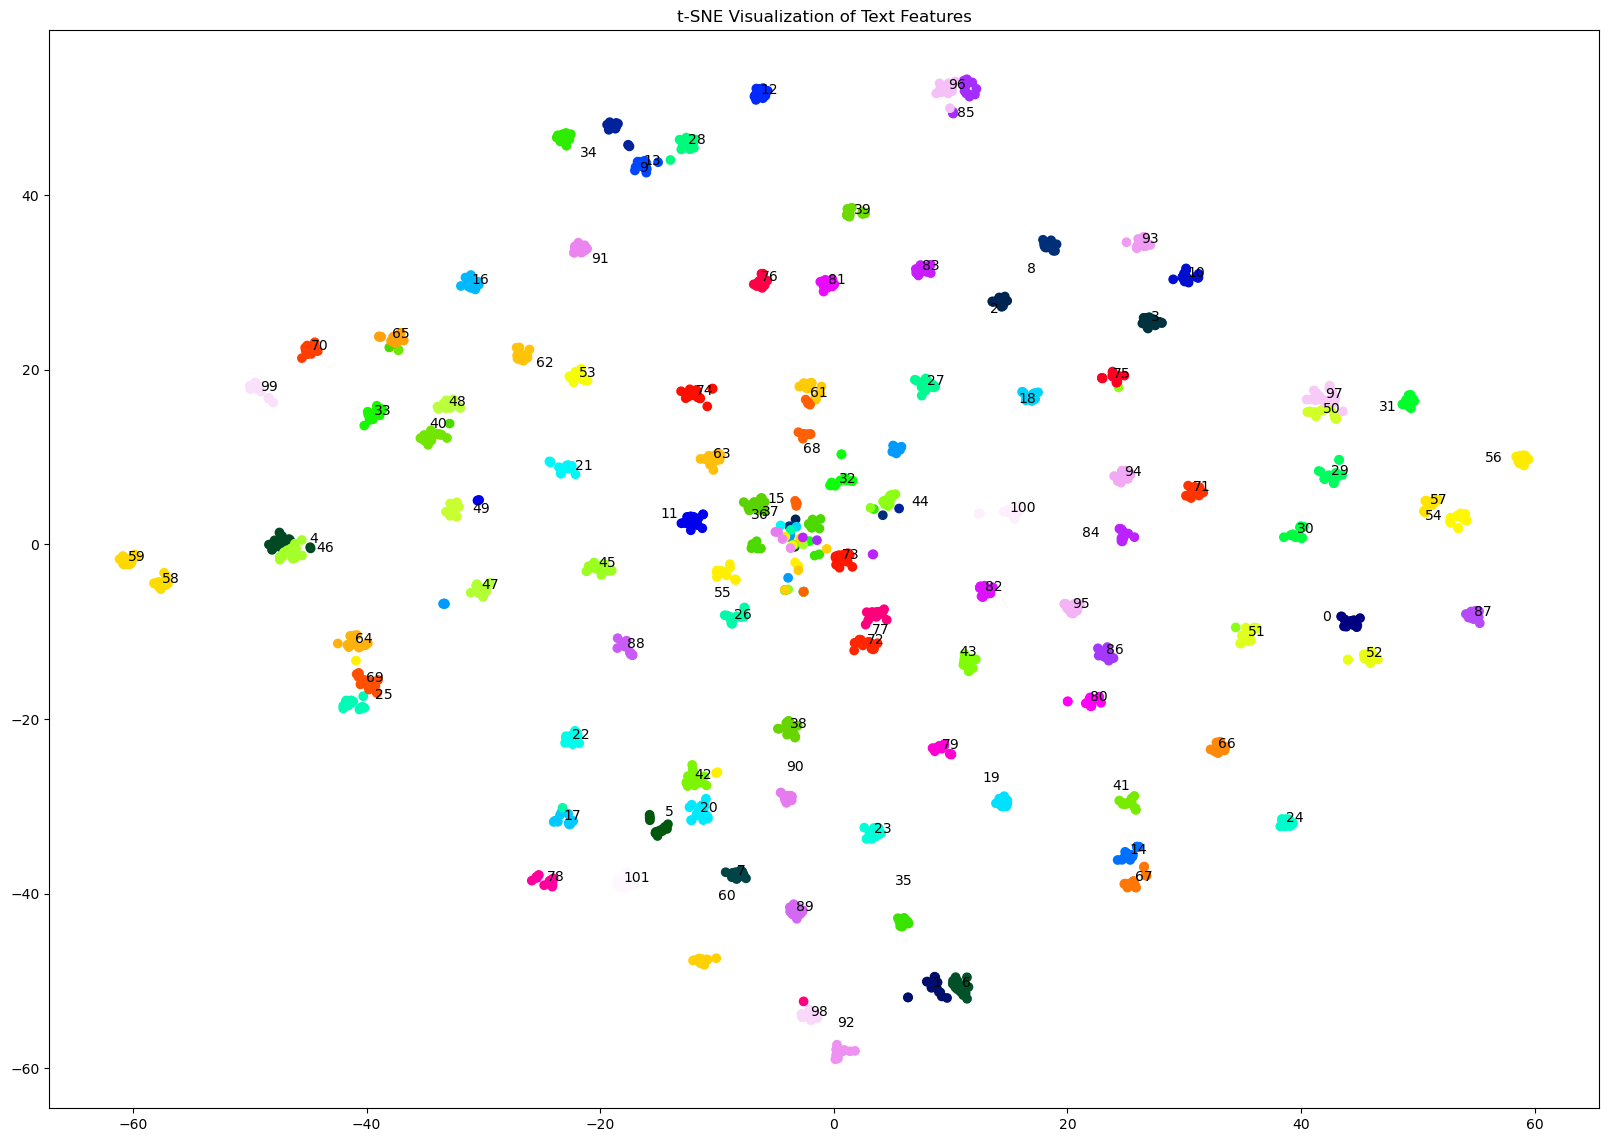

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 14))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=label_ids, cmap='gist_ncar')
for label_id in range(len(classnames_sorted)):
    plt.annotate(label_id, (tsne_features[label_ids == label_id, 0].mean(), tsne_features[label_ids == label_id, 1].mean()))
plt.title('t-SNE Visualization of Text Features')
plt.show()